In [1]:
%load_ext autoreload
%autoreload 1

import gc
import os
import sys
import time
from pprint import pprint

import googlemaps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from scipy.integrate import odeint

main_dir = os.path.abspath(os.pardir)
sys.path.insert(0, main_dir)
from analysis.download_data import jh_git_url, all_files
from covid_forecast.utils import data_prep as dp

pd.options.display.max_rows = 999
pd.options.display.max_columns = 100
pd.options.display.precision = 2
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
print(main_dir)

D:\Users\gjnet\code_projects\covid_forecast


# Open files as dataframes
Credit to dgrechka for locations_population. Data[source](https://www.kaggle.com/dgrechka/covid19-global-forecasting-locations-population/metadata)

In [3]:
locations_population = pd.read_csv(os.path.join(main_dir, "data", "raw", "locations_population.csv"))
friendly_fnames = [file.replace("time_series_covid19_", "").replace(".csv", "") for file in all_files]
filename_dct = dict(zip(friendly_fnames, all_files))
pprint(filename_dct)

{'confirmed_global': 'time_series_covid19_confirmed_global.csv',
 'deaths_global': 'time_series_covid19_deaths_global.csv',
 'recovered_global': 'time_series_covid19_recovered_global.csv'}


In [4]:
df_dct = dict()
for file in filename_dct.keys():
    df_dct[file] = pd.read_csv(jh_git_url+filename_dct[file])  # reads csv from github repo
    exec(file+" = df_dct['"+file+"']")  # creates a reference for friendly_names
    print(file, df_dct[file].shape)
    display(df_dct[file].head(), df_dct[file].describe(include="all"), df_dct[file].dtypes)

confirmed_global (253, 71)


Province/State Country/Region    Lat  Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.00 65.00        0        0        0   
1            NaN        Albania  41.15 20.17        0        0        0   
2            NaN        Algeria  28.03  1.66        0        0        0   
3            NaN        Andorra  42.51  1.52        0        0        0   
4            NaN         Angola -11.20 17.87        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        1        1        1   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        1        1   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        1        1        1       1       1       1       1       1       1   
1        0        0        0       0       0       0       0       0       0   
2        1        1        1       1       3       5      12      12      17   
3        0        0        0       0       1       1       1       1       1   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       1       4       4        5        7        7        7       11   
1       0       0       2       10       12       23       33       38   
2      17      19      20       20       20       24       26       37   
3       1       1       1        1        1        1        1        1   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0       16       21       22       22       22       24       24       40   
1       42       51       55       59       64       70       76       89   
2       48       54       60       74       87       90      139      201   
3        1        2       39       39       53       75       88      113   
4        0        0        0        0        0        1        2        2   

   3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  3/28/20  
0       40       74       84       94      110      110  
1      104      123      146      174      186      197  
2      230      264      302      367      409      454  
3      133      164      188      224      267      308  
4        3        3 

Province/State Country/Region    Lat    Long  1/22/20  1/23/20  \
count                 79            253 253.00  253.00   253.00   253.00   
unique                79            177    nan     nan      nan      nan   
top     Saint Barthelemy          China    nan     nan      nan      nan   
freq                   1             33    nan     nan      nan      nan   
mean                 NaN            NaN  22.15   23.26     2.19     2.58   
std                  NaN            NaN  24.40   71.51    27.97    28.07   
min                  NaN            NaN -41.45 -135.00     0.00     0.00   
25%                  NaN            NaN   8.54  -19.02     0.00     0.00   
50%                  NaN            NaN  23.83   20.90     0.00     0.00   
75%                  NaN            NaN  41.30   85.24     0.00     0.00   
max                  NaN            NaN  71.71  178.06   444.00   444.00   

        1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  \
count    253.00   253.00   253.00   253.00   253.00   253.00   253.00   
unique      nan      nan      nan      nan      nan      nan      nan   
top         nan      nan      nan      nan      nan      nan      nan   
freq        nan      nan      nan      nan      nan      nan      nan   
mean       3.72     5.67     8.37    11.57    22.05    24.37    32.55   
std       34.94    48.63    67.95    91.55   224.72   226.08   311.55   
min        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
25%        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
50%        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
75%        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
max      549.00   761.00 1,058.00 1,423.00 3,554.00 3,554.00 4,903.00   

        1/31/20   2/1/20    2/2/20    2/3/20    2/4/20    2/5/20    2/6/20  \
count    253.00   253.00    253.00    253.00    253.00    253.00    253.00   
unique      nan      nan       nan       nan       nan       nan       nan   
top         nan      nan       nan       nan       nan       nan       nan   
freq        nan      nan       nan       nan       nan       nan       nan   
mean      39.24    47.58     66.35     78.58     94.43    109.23    121.72   
std      369.37   454.54    706.43    853.99  1,052.52  1,240.33  1,394.31   
min        0.00     0.00      0.00      0.00      0.00      0.00      0.00   
25%        0.00     0.00      0.00      0.00      0.00      0.00      0.00   
50%        0.00     0.00      0.00      0.00      0.00      0.00      0.00   
75%        0.00     0.00      0.00      0.00      0.00      0.00      0.00   
max    5,806.00 7,153.00 11,177.00 13,522.00 16,678.00 19,665.00 22,112.00   

          2/7/20    2/8/20    2/9/20   2/10/20   2/11/20   2/12/20   2/13/20  \
count     253.00    253.00    253.00    253.00    253.00    253.00    253.00   
unique       nan       nan       nan       nan       nan       nan       nan   
top          nan       nan       nan       nan       nan       nan       nan   
freq         nan       nan       nan       nan       nan       nan       nan   
mean      135.93    146.72    158.70    169.02    177.08    178.74    238.61   
std     1,572.91  1,707.95  1,866.95  1,998.70  2,101.65  2,101.99  3,032.92   
min         0.00      0.00      0.00      0.00      0.00      0.00      0.00   
25%         0.00      0.00      0.00      0.00      0.00      0.00      0.00   
50%         0.00      0.00      0.00      0.00      0.00      0.00      0.00   
75%         0.00      0.00      0.00      0.00      0.00      0.00      0.00   
max    24,953.00 27,100.00 29,631.00 31,728.00 33,366.00 33,366.00 48,206.00   

         2/14/20   2/15/20   2/16/20   2/17/20   2/18/20   2/19/20   2/20/20  \
count     253.00    253.00    253.00    253.00    253.00    253.00    253.00   
unique       nan       nan       nan       nan       nan       nan       nan   
top          nan       nan       nan       nan       nan       nan       nan   
fr

Province/State     object
Country/Region     object
Lat               float64
Long              float64
1/22/20             int64
1/23/20             int64
1/24/20             int64
1/25/20             int64
1/26/20             int64
1/27/20             int64
1/28/20             int64
1/29/20             int64
1/30/20             int64
1/31/20             int64
2/1/20              int64
2/2/20              int64
2/3/20              int64
2/4/20              int64
2/5/20              int64
2/6/20              int64
2/7/20              int64
2/8/20              int64
2/9/20              int64
2/10/20             int64
2/11/20             int64
2/12/20             int64
2/13/20             int64
2/14/20             int64
2/15/20             int64
2/16/20             int64
2/17/20             int64
2/18/20             int64
2/19/20             int64
2/20/20             int64
2/21/20             int64
2/22/20             int64
2/23/20             int64
2/24/20             int64
2/25/20     

deaths_global (253, 71)


Province/State Country/Region    Lat  Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.00 65.00        0        0        0   
1            NaN        Albania  41.15 20.17        0        0        0   
2            NaN        Algeria  28.03  1.66        0        0        0   
3            NaN        Andorra  42.51  1.52        0        0        0   
4            NaN         Angola -11.20 17.87        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        0        0        0       0       0       0       0       0       0   
1        0        0        0       0       0       0       0       0       0   
2        0        0        0       0       0       0       0       0       0   
3        0        0        0       0       0       0       0       0       0   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       0       0       0        0        0        0        0        0   
1       0       0       0        0        1        1        1        1   
2       0       0       0        0        0        1        2        3   
3       0       0       0        0        0        0        0        0   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0        0        0        0        0        0        0        0        1   
1        1        1        1        2        2        2        2        2   
2        4        4        4        7        9       11       15       17   
3        0        0        0        0        0        0        0        1   
4        0        0        0        0        0        0        0        0   

   3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  3/28/20  
0        1        1        2        4        4        4  
1        4        5        5        6        8       10  
2       17       19       21       25       26       29  
3        1        1        1        3        3        3  
4        0        0 

Province/State Country/Region    Lat    Long  1/22/20  1/23/20  \
count                 79            253 253.00  253.00   253.00   253.00   
unique                79            177    nan     nan      nan      nan   
top     Saint Barthelemy          China    nan     nan      nan      nan   
freq                   1             33    nan     nan      nan      nan   
mean                 NaN            NaN  22.15   23.26     0.07     0.07   
std                  NaN            NaN  24.40   71.51     1.07     1.07   
min                  NaN            NaN -41.45 -135.00     0.00     0.00   
25%                  NaN            NaN   8.54  -19.02     0.00     0.00   
50%                  NaN            NaN  23.83   20.90     0.00     0.00   
75%                  NaN            NaN  41.30   85.24     0.00     0.00   
max                  NaN            NaN  71.71  178.06    17.00    17.00   

        1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  \
count    253.00   253.00   253.00   253.00   253.00   253.00   253.00   
unique      nan      nan      nan      nan      nan      nan      nan   
top         nan      nan      nan      nan      nan      nan      nan   
freq        nan      nan      nan      nan      nan      nan      nan   
mean       0.10     0.17     0.22     0.32     0.52     0.53     0.68   
std        1.51     2.52     3.27     4.78     7.86     7.86    10.19   
min        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
25%        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
50%        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
75%        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
max       24.00    40.00    52.00    76.00   125.00   125.00   162.00   

        1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  \
count    253.00  253.00  253.00  253.00  253.00  253.00  253.00  253.00   
unique      nan     nan     nan     nan     nan     nan     nan     nan   
top         nan     nan     nan     nan     nan     nan     nan     nan   
freq        nan     nan     nan     nan     nan     nan     nan     nan   
mean       0.84    1.02    1.43    1.68    1.94    2.23    2.51    2.84   
std       12.83   15.65   22.00   26.03   30.11   34.51   38.85   43.94   
min        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
25%        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
50%        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
75%        0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
max      204.00  249.00  350.00  414.00  479.00  549.00  618.00  699.00   

        2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  \
count   253.00  253.00   253.00   253.00   253.00   253.00   253.00   253.00   
unique     nan     nan      nan      nan      nan      nan      nan      nan   
top        nan     nan      nan      nan      nan      nan      nan      nan   
freq       nan     nan      nan      nan      nan      nan      nan      nan   
mean      3.19    3.58     4.00     4.40     4.42     5.42     6.02     6.58   
std      49.03   54.75    61.23    67.14    67.14    82.35    91.59   100.33   
min       0.00    0.00     0.00     0.00     0.00     0.00     0.00     0.00   
25%       0.00    0.00     0.00     0.00     0.00     0.00     0.00     0.00   
50%       0.00    0.00     0.00     0.00     0.00     0.00     0.00     0.00   
75%       0.00    0.00     0.00     0.00     0.00     0.00     0.00     0.00   
max     780.00  871.00   974.00 1,068.00 1,068.00 1,310.00 1,457.00 1,596.00   

        2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  \
count    253.00   253.00   253.00   253.00   253.00   253.00   253.00   
unique      nan      nan      nan      nan      nan      nan      nan   
top         nan      nan      nan      nan      nan      nan      nan   
freq        nan      nan      nan      nan      nan      nan      

Province/State     object
Country/Region     object
Lat               float64
Long              float64
1/22/20             int64
1/23/20             int64
1/24/20             int64
1/25/20             int64
1/26/20             int64
1/27/20             int64
1/28/20             int64
1/29/20             int64
1/30/20             int64
1/31/20             int64
2/1/20              int64
2/2/20              int64
2/3/20              int64
2/4/20              int64
2/5/20              int64
2/6/20              int64
2/7/20              int64
2/8/20              int64
2/9/20              int64
2/10/20             int64
2/11/20             int64
2/12/20             int64
2/13/20             int64
2/14/20             int64
2/15/20             int64
2/16/20             int64
2/17/20             int64
2/18/20             int64
2/19/20             int64
2/20/20             int64
2/21/20             int64
2/22/20             int64
2/23/20             int64
2/24/20             int64
2/25/20     

recovered_global (239, 71)


Province/State Country/Region    Lat  Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.00 65.00        0        0        0   
1            NaN        Albania  41.15 20.17        0        0        0   
2            NaN        Algeria  28.03  1.66        0        0        0   
3            NaN        Andorra  42.51  1.52        0        0        0   
4            NaN         Angola -11.20 17.87        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        0        0        0       0       0       0       0       0       0   
1        0        0        0       0       0       0       0       0       0   
2        0        0        0       0       0       0       0       0       0   
3        0        0        0       0       0       0       0       0       0   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       0       0       0        0        0        0        0        0   
1       0       0       0        0        0        0        0        0   
2       0       0       0        0        0        8        8       12   
3       0       0       0        0        0        1        0        1   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0        0        1        1        1        1        1        1        1   
1        0        0        0        0        0        0        2        2   
2       12       12       12       12       32       32       32       65   
3        1        1        1        1        1        1        1        1   
4        0        0        0        0        0        0        0        0   

   3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  3/28/20  
0        1        1        2        2        2        2  
1        2       10       17       17       31       31  
2       65       24       65       29       29       31  
3        1        1        1        1        1        1  
4        0        0 

Province/State Country/Region    Lat    Long  1/22/20  1/23/20  \
count                 64            239 239.00  239.00   239.00   239.00   
unique                64            177    nan     nan      nan      nan   
top     Saint Barthelemy          China    nan     nan      nan      nan   
freq                   1             33    nan     nan      nan      nan   
mean                 NaN            NaN  20.87   29.36     0.12     0.13   
std                  NaN            NaN  24.07   68.09     1.81     1.82   
min                  NaN            NaN -41.45 -106.35     0.00     0.00   
25%                  NaN            NaN   7.74   -7.00     0.00     0.00   
50%                  NaN            NaN  22.30   22.94     0.00     0.00   
75%                  NaN            NaN  39.77   90.39     0.00     0.00   
max                  NaN            NaN  71.71  178.06    28.00    28.00   

        1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  \
count    239.00   239.00   239.00   239.00   239.00   239.00   239.00   
unique      nan      nan      nan      nan      nan      nan      nan   
top         nan      nan      nan      nan      nan      nan      nan   
freq        nan      nan      nan      nan      nan      nan      nan   
mean       0.15     0.16     0.22     0.26     0.45     0.53     0.60   
std        2.01     2.08     2.73     2.93     5.21     5.73     5.89   
min        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
25%        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
50%        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
75%        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
max       31.00    32.00    42.00    45.00    80.00    88.00    90.00   

        1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20   2/7/20  \
count    239.00  239.00  239.00  239.00  239.00  239.00  239.00   239.00   
unique      nan     nan     nan     nan     nan     nan     nan      nan   
top         nan     nan     nan     nan     nan     nan     nan      nan   
freq        nan     nan     nan     nan     nan     nan     nan      nan   
mean       0.93    1.19    1.97    2.61    3.56    4.70    6.22     8.41   
std        9.22   11.04   19.28   25.25   34.19   41.67   53.85    73.44   
min        0.00    0.00    0.00    0.00    0.00    0.00    0.00     0.00   
25%        0.00    0.00    0.00    0.00    0.00    0.00    0.00     0.00   
50%        0.00    0.00    0.00    0.00    0.00    0.00    0.00     0.00   
75%        0.00    0.00    0.00    0.00    0.00    0.00    0.00     0.00   
max      141.00  168.00  295.00  386.00  522.00  633.00  817.00 1,115.00   

         2/8/20   2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  \
count    239.00   239.00   239.00   239.00   239.00   239.00   239.00   
unique      nan      nan      nan      nan      nan      nan      nan   
top         nan      nan      nan      nan      nan      nan      nan   
freq        nan      nan      nan      nan      nan      nan      nan   
mean      10.95    13.57    16.51    19.59    21.55    26.34    33.72   
std       94.96   118.33   146.26   173.58   177.98   227.98   312.67   
min        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
25%        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
50%        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
75%        0.00     0.00     0.00     0.00     0.00     0.00     0.00   
max    1,439.00 1,795.00 2,222.00 2,639.00 2,686.00 3,459.00 4,774.00   

        2/15/20  2/16/20  2/17/20  2/18/20   2/19/20   2/20/20   2/21/20  \
count    239.00   239.00   239.00   239.00    239.00    239.00    239.00   
unique      nan      nan      nan      nan       nan       nan       nan   
top         nan      nan      nan      nan       nan       nan       nan   
freq        nan      nan      nan      nan       nan       nan       nan   
mean      39.31    45.46    52.65    60.05     67.

Province/State     object
Country/Region     object
Lat               float64
Long              float64
1/22/20             int64
1/23/20             int64
1/24/20             int64
1/25/20             int64
1/26/20             int64
1/27/20             int64
1/28/20             int64
1/29/20             int64
1/30/20             int64
1/31/20             int64
2/1/20              int64
2/2/20              int64
2/3/20              int64
2/4/20              int64
2/5/20              int64
2/6/20              int64
2/7/20              int64
2/8/20              int64
2/9/20              int64
2/10/20             int64
2/11/20             int64
2/12/20             int64
2/13/20             int64
2/14/20             int64
2/15/20             int64
2/16/20             int64
2/17/20             int64
2/18/20             int64
2/19/20             int64
2/20/20             int64
2/21/20             int64
2/22/20             int64
2/23/20             int64
2/24/20             int64
2/25/20     

In [5]:
# Start timer
start_time = pd.to_datetime("now")
time_fmt = "%d/%m/%Y %H:%M:%S"
print("INFO: start time", start_time.strftime(time_fmt))

# Filling missing province/state where possible
gmaps = googlemaps.Client(key=os.getenv("gmaps_api_key"))

match_keys = ["Province/State", "Country/Region", "Lat", "Long"]
fillna_keys = ["Province/State", "Country/Region"]
prov_state_vname = "Province/State"
country_region_vname = "Country/Region"
loc_admin_long_vname = "long_name"

# Start with the first df with missing province/state values
temp_df = confirmed_global[match_keys][confirmed_global[prov_state_vname].isna()].copy()

for i in temp_df.index:
    row = temp_df.loc[i]

    # Look up an address with reverse geocoding
    try:
        target_loc = gmaps.reverse_geocode((row["Lat"], row["Long"]))[0]['address_components']
    except IndexError:
        continue
    admin_ind = dp.find_admin_loc(target_loc)
    if admin_ind is not None:
        temp_df.loc[i, prov_state_vname] = target_loc[dp.find_admin_loc(target_loc)][loc_admin_long_vname]
    
    # Fill missing with country/region
    temp_df[prov_state_vname] = temp_df[prov_state_vname].fillna(temp_df[country_region_vname])
    
    # Gmaps anti-throttling tactic
    time.sleep(1)  # wait 1 second before the next iteration

# Fillna missing values
for df in df_dct.keys():
    df_dct[df][fillna_keys] = confirmed_global[fillna_keys].fillna(temp_df[fillna_keys])

# Finish time
finish_time = pd.to_datetime("now")
elapsed_time_min = round((finish_time-start_time).total_seconds()/60, 2)
print("INFO: finished. This took", elapsed_time_min, "minutes.")

INFO: start time 29/03/2020 01:17:02
INFO: finished. This took 0.4 minutes.


In [6]:
# Population df formatting
# Credit to lisphilar. Source code: https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model
df = locations_population.copy()
df = df.rename({"Province.State": "Province", "Country.Region": "Country"}, axis=1)
cols = ["Country", "Province", "Population"]
df = df.loc[:, cols].fillna("-")
df.loc[df["Country"] == df["Province"], "Province"] = "-"

# Add total records
_total_df = df.loc[df["Province"] != "-", :].groupby("Country").sum()
_total_df = _total_df.reset_index().assign(Province="-")
df = pd.concat([df, _total_df], axis=0, sort=True)
df = df.drop_duplicates(subset=["Country", "Province"], keep="first")

# Global
global_value = df.loc[df["Province"] == "-", "Population"].sum()
df = df.append(pd.Series(["Global", "-", global_value], index=cols), ignore_index=True)

# Global except China
china_value = df.loc[(df["Country"] == "China") & (df["Province"] == "-"), "Population"].sum()
except_china_value = global_value - china_value
df = df.append(pd.Series(["Except China", "-", except_china_value], index=cols), ignore_index=True)

# Sorting
df = df.sort_values("Population", ascending=False).reset_index(drop=True)
df = df.loc[:, cols]
population_df = df.copy()
population_df.head()

Country Province  Population
0        Global        -  7067093478
1  Except China        -  5690286216
2         China        -  1376807262
3         India        -  1339000000
4            US        -   327200000

In [7]:
df_dct = dp.bulk_reduce_mem(df_dct)
population_df = population_df.pipe(dp.reduce_mem)
gc.collect()

0

# SIR
[Source code](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)

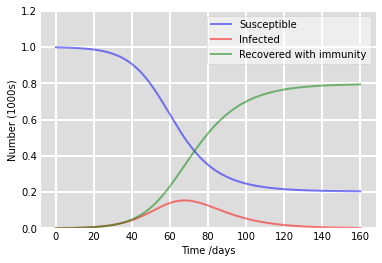

In [10]:
# Total population, N.
N = 1000

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Contact rate (aka beta), and mean recovery rate aka (gamma) both (in 1/days).
beta, gamma = 0.2, 1./10 

# A grid of time points (in days)
days = 160
t = np.linspace(0, days, days)

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(dp.deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_facecolor('#dddddd')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()